# Project Name

---

## Table of Contents <a name="toc"></a>

---

- 1.[**Data Source Information**](#datasource)
- 2.[**Setup**](#setup)
  - 2.1. [Environment Details for Reproducility](#env)
  - 2.2. [Importing the Data](#dataimport)
- 3.[**Data Preprocessing**](#datapre)


## 1. Data Source Information <a name="datasource"></a>

---


## 2. Setup <a name="setup"></a>

---


In [181]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, AutoDateFormatter

from prophet import Prophet

### 2.1. Environment Information for Reproducibility: <a name="env"></a>

### 2.2. Importing the Data: <a name="dataimport"></a>

In [182]:
# Set directories
current_wdir = os.getcwd()
data_folder_hourly = current_wdir + '/Data/Hourly_Load'
data_folder_gen = current_wdir + '/Data/Gen_by_Fuel'
data_folder_weather = current_wdir + '/Data/Weather'

In [183]:
# Add and sort all filenames from each folder path.
file_path_load = [f'{data_folder_hourly}/{file}' for file in os.listdir(data_folder_hourly) if '.csv' in file]
file_path_load = sorted(file_path_load)

file_path_gen = [f'{data_folder_gen}/{file}' for file in os.listdir(data_folder_gen) if '.csv' in file]
file_path_gen = sorted(file_path_gen)

file_path_weather = [f'{data_folder_weather}/{file}' for file in os.listdir(data_folder_weather) if '.csv' in file]
file_path_weather = sorted(file_path_weather)

# Iterate through filenames and add them to dataframe.
# pd.read_csv can unzip as it goes with compression argument.
load_df = pd.concat([pd.read_csv(file, compression = 'gzip') for file in file_path_load], join = 'outer', ignore_index = False, axis = 0)
gen_df = pd.concat([pd.read_csv(file, compression = 'gzip') for file in file_path_gen], join = 'outer', ignore_index = False, axis = 0)
weather_df_list = []
for filename in file_path_weather:
    # delimiter has whitespace after comma, specified here as \s+.
    temp_df = pd.read_csv(filename, compression = 'gzip', delimiter = ',\s+', engine = 'python')
    temp_df['zone']= os.path.basename(filename).replace('.csv.gz', '')
    weather_df_list.append(temp_df)
weather_df = pd.concat(weather_df_list, join = 'outer', ignore_index = False, axis = 0)

## 3. Data Preprocessing <a name="datapre"></a>

---

### 3.1. First Looks: <a name="firstlook"></a>

In [184]:
display(load_df)
display(load_df.dtypes)

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,BC,BC,2358.000,True
1,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,CNCT,AE,855.000,True
2,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,CNCT,DPL,1150.000,True
3,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,GPU,JC,1632.000,True
4,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,GPU,ME,929.000,True
...,...,...,...,...,...,...,...,...
62605,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,RECO,RECO,131.877,False
62606,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,PEP,SMECO,355.931,False
62607,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,PL,UGI,101.478,True
62608,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,AE,VMEU,70.051,False


datetime_beginning_utc     object
datetime_beginning_ept     object
nerc_region                object
mkt_region                 object
zone                       object
load_area                  object
mw                        float64
is_verified                  bool
dtype: object

In [185]:
display(gen_df)
display(gen_df.dtypes)

,datetime_beginning_utc,datetime_beginning_ept,fuel_type,mw,fuel_percentage_of_total,is_renewable
0,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Coal,34820,0.41,False
1,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Gas,11169,0.13,False
2,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Hydro,699,0.01,True
3,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Multiple Fuels,266,0.00,False
4,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Nuclear,34269,0.41,False
...,...,...,...,...,...,...
21095,1/1/2024 5:00:00 AM,1/1/2024 12:00:00 AM,Oil,221,0.00,False
21096,1/1/2024 5:00:00 AM,1/1/2024 12:00:00 AM,Other Renewables,690,0.01,True
21097,1/1/2024 5:00:00 AM,1/1/2024 12:00:00 AM,Solar,12,0.00,True
21098,1/1/2024 5:00:00 AM,1/1/2024 12:00:00 AM,Storage,0,0.00,False


datetime_beginning_utc       object
datetime_beginning_ept       object
fuel_type                    object
mw                            int64
fuel_percentage_of_total    float64
is_renewable                   bool
dtype: object

In [186]:
display(weather_df)
display(weather_df.dtypes)

,Date,MaxTemperature,MinTemperature,AvgTemperature,Precipitation,zone
0,2015-01-01,43,17,30.0,0.00,AE
1,2015-01-02,45,24,34.5,0.00,AE
2,2015-01-03,47,21,34.0,0.62,AE
3,2015-01-04,64,46,55.0,0.26,AE
4,2015-01-05,50,25,37.5,0.00,AE
...,...,...,...,...,...,...
11417,2024-04-05,57,40,48.5,0.00,PEP
11418,2024-04-06,57,41,49.0,0.00,PEP
11419,2024-04-07,65,43,54.0,0.00,PEP
11420,2024-04-08,71,44,57.5,0.00,PEP


Date              object
MaxTemperature    object
MinTemperature    object
AvgTemperature    object
Precipitation     object
zone              object
dtype: object

### 3.2. Reformating: <a name="reformat"></a>

In [187]:
# Convert to datetime. The two dataframes share column names.
date_cols = ['datetime_beginning_utc', 'datetime_beginning_ept']
load_df[date_cols] = load_df[date_cols].apply(pd.to_datetime, format = '%m/%d/%Y %I:%M:%S %p', utc = False)
gen_df[date_cols] = gen_df[date_cols].apply(pd.to_datetime, format = '%m/%d/%Y %I:%M:%S %p', utc = False)
weather_df['Date'] = weather_df['Date'].apply(pd.to_datetime, format = '%Y-%m-%d', utc = False)

In [188]:
sorted(load_df['zone'].unique())

['AE',
 'AEP',
 'AP',
 'ATSI',
 'BC',
 'CE',
 'CNCT',
 'DAY',
 'DEOK',
 'DOM',
 'DPL',
 'DUQ',
 'EKPC',
 'GPU',
 'JC',
 'ME',
 'OVEC',
 'PE',
 'PEP',
 'PL',
 'PN',
 'PS',
 'RECO',
 'RTO']

Zones

`AE` - New Jersey
`AEP` - Ohio
`AP` - West Virginia
`ATSI` - Ohio
`BC` - Maryland
`CE` - Northern Illinois
`CNCT` - Connecticut
`DAY` - Ohio
`DEOK` - Ohio
`DOM` - Virginia
`DPL` - Connecticut
`DUQ` - Pennsylvania
`EKPC` - Kentucky
`GPU` - New Jersey
`JC` - New Jersey
`ME` - Pennsylvania
`OVEC` - Ohio
`PE` - Pennsylvania
`PEP` - Maryland
`PL` - Pennsylvania
`PN` - Pennsylvania
`PS` - New Jersey
`RECO` - New Jersey

`RTO` - Regional Transmission Organization (PJM) - Aggregated Sum

In [189]:
load_zone_df = load_df[['datetime_beginning_ept', 'zone', 'mw']].groupby(['datetime_beginning_ept', 'zone'], as_index = False).sum()

In [190]:
load_noRTO_df = load_zone_df.drop(load_zone_df[load_zone_df['zone'] == 'RTO'].index)

### 3.3. Discovery: <a name="discovery"></a>

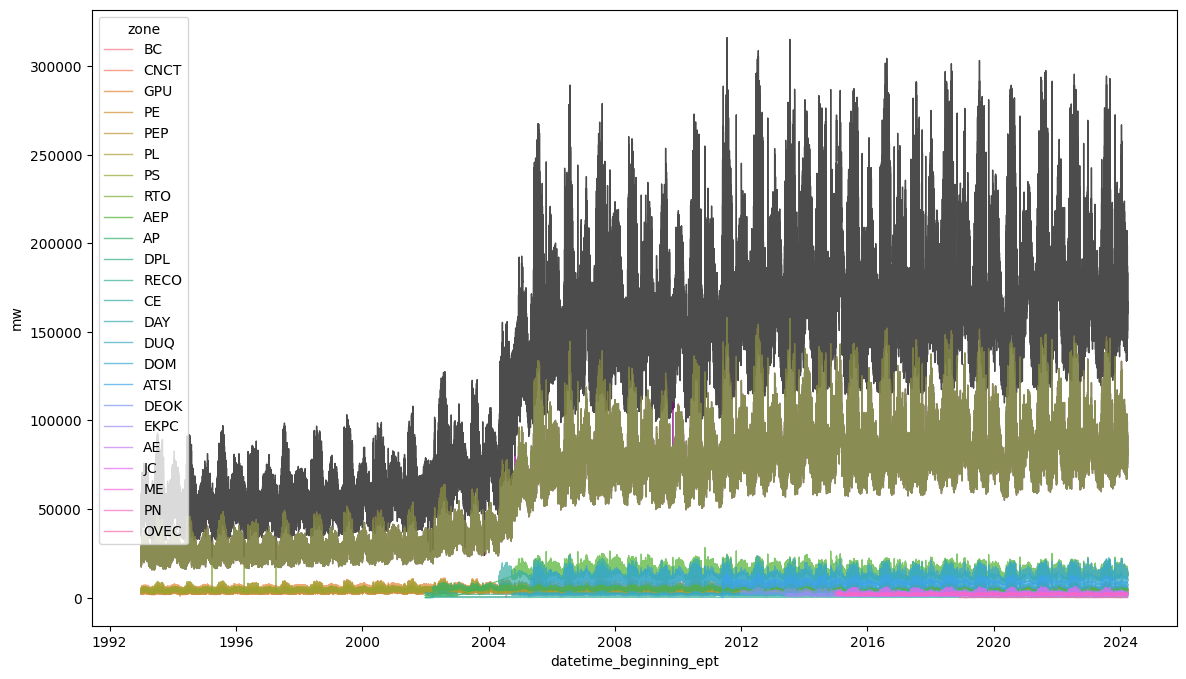

In [191]:
ax, fig = plt.subplots(figsize = (14, 8))
# Black - Sum of ALL
ax = sns.lineplot(load_zone_df[['datetime_beginning_ept', 'mw']].groupby(['datetime_beginning_ept'], as_index = False).sum(), x = 'datetime_beginning_ept', y = 'mw', alpha = 0.7, lw = 1, c = 'black')
# Purple - Sum of All but NO RTO
ax = sns.lineplot(load_noRTO_df[['datetime_beginning_ept', 'mw']].groupby(['datetime_beginning_ept'], as_index = False).sum(), x = 'datetime_beginning_ept', y = 'mw', alpha = 0.7, lw = 1, c = 'purple')
ax = sns.lineplot(load_zone_df, x = 'datetime_beginning_ept', y = 'mw',  hue = 'zone', alpha = 0.7, lw = 1)

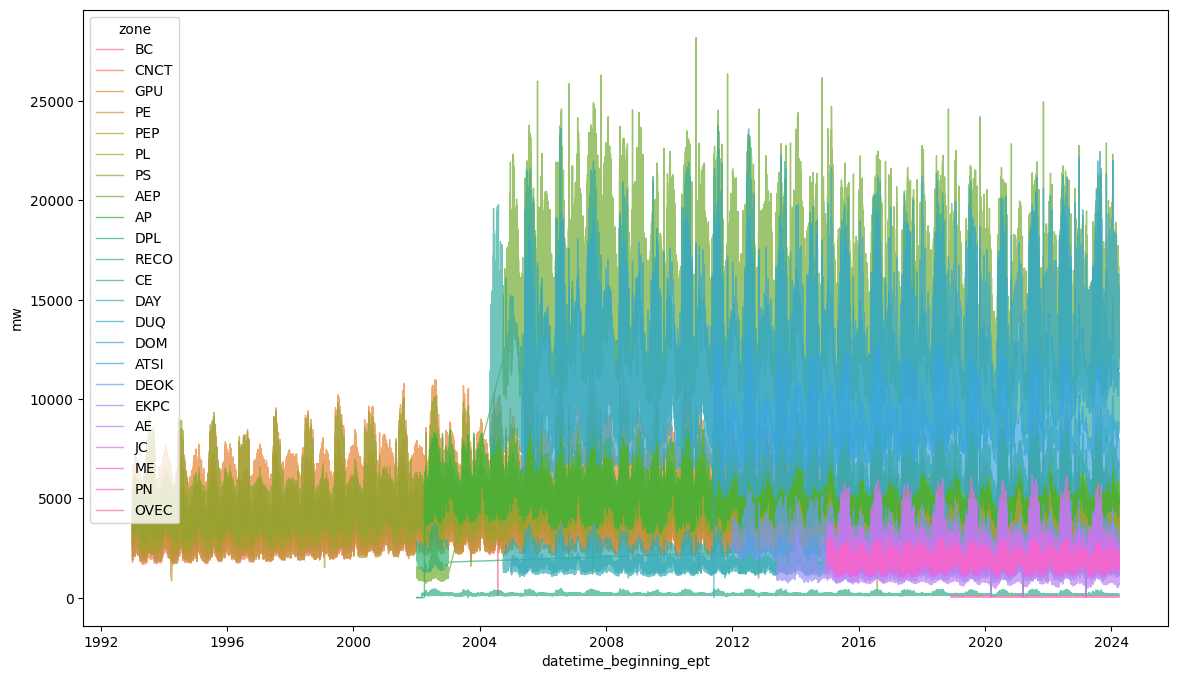

In [192]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(load_noRTO_df[['datetime_beginning_ept', 'mw', 'zone']].groupby(['datetime_beginning_ept', 'zone'], as_index = False).sum(), x = 'datetime_beginning_ept', y = 'mw', hue = 'zone', alpha = 0.7, lw = 1)

In [193]:
def load_zone_plot(zone_df, outliers=None, figsize=(16,16), cmap=None):
    """Finds all unique zone names and prints to output (n x 2) subplot array of line plots where x = datetime vs y = MW. 
    Can handle any length of list of strings.

    Parameters:
        zones_df (list): Pandas dataframe grouped by zone and time such as load_zone_df.
    Optional Parameters:
        outliers (dict): List of outlier indexes that will be plotted as points on top of line plot. Has the form of {'Zone' : [idx, idx, ...]}
        figsize (tuple): Default = (16,16)
    Returns:
        None. Prints plot to output."""
    
    zone_list = zone_df['zone'].unique()

    color_pal = ['#005d5d', '#017d66']
    
    fig, ax = plt.subplots(int(np.ceil(len(zone_list)/2)), 2, figsize = figsize, sharey = False, sharex = False)
    for i, zone in enumerate(zone_list):
        #print(f'{i} {zone} -- [{i//2}, {i%2}]')
        # i iterates through axes rows and columns with // and % operators 
        # ([0,0] to [0,1] to [1,0] ... etc).
        sns.lineplot(load_zone_df.loc[load_zone_df['zone'] == zone], ax = ax[i//2, i%2], 
                     x = 'datetime_beginning_ept', y = 'mw', 
                     alpha = 0.7, lw = 1,
                     c = cmap[zone] if cmap else (color_pal[int(i % 4 < 2)]))
        ax[i//2, i%2].set_title(zone, y = 1)
        ax[i//2, i%2].set_xlabel(None)
        ax[i//2, i%2].set_ylabel(None)

        # If given outlier indexes, plot them.
        if outliers:
            sns.scatterplot(load_zone_df.iloc[outliers.get(zone)], ax = ax[i//2, i%2],
                            x = 'datetime_beginning_ept', y = 'mw',
                            c = 'black')
        
    plt.subplots_adjust(wspace = 0.3, hspace = 1)
    fig.suptitle('Hourly Load of Each Zone')
    fig.supxlabel('Datetime')
    fig.supylabel('Megawatts (MW)')
    fig.tight_layout()

    # Check if odd number of plots and delete last subplot if true.
    if len(zone_list) % 2 != 0:
        fig.delaxes(ax[i // 2, (len(zone_list) % 2)])
    
    return None

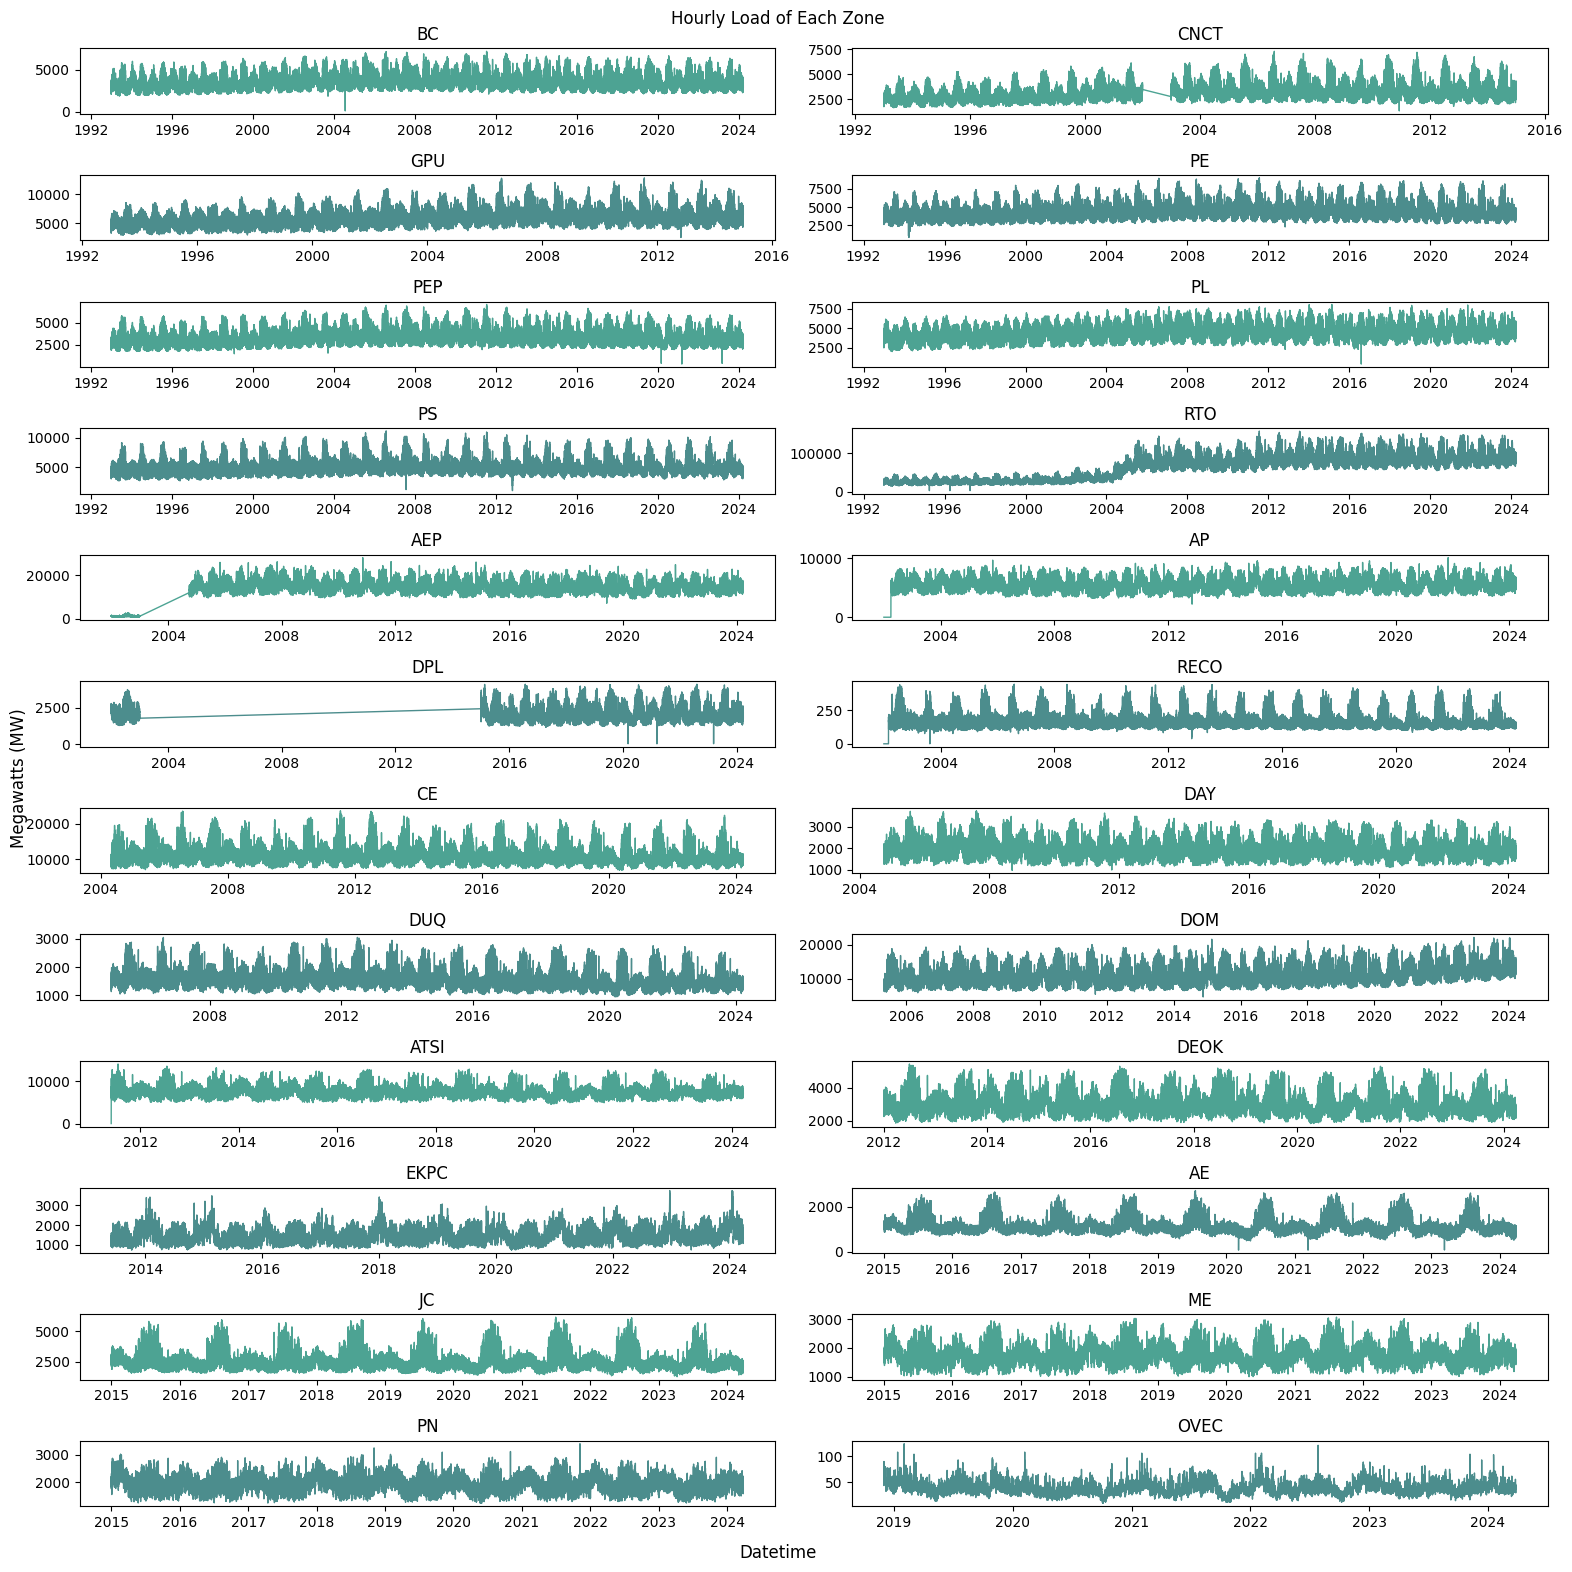

In [194]:
load_zone_plot(load_zone_df)

### 3.4. Selecting Electrical Load Data: <a name="dataselection"></a>

- `AE`: Atlantic City Electric Co. 
- `CE`: ComEd
- `DOM`: Dominion
- `JC`: Jersey Central Power & Light
- `PEP`: Potomac Electric Power Co.

In [195]:
zones = ['AE', 'CE', 'DOM', 'JC', 'PEP']
load_zone_df = load_zone_df.loc[load_zone_df['zone'].isin(zones)]
load_zone_df.reset_index(drop = True, inplace = True)

# Color map zones for consistency.
palette = ['#570408', '#005d5d', '#1192e8', '#fa4d56', '#012749']
zones_palette = dict(zip(zones, palette))

*Note about the weather data:*

Weather data was sourced from National Oceanic and Atmospheric Administration's (NOAA) Regional Climate Center (RCC) Applied Climate Information System (ACIS). Detailed information can be found in section 1. For readability and organizational purposes the weather data was imported above along with the other datasets.

Ideally, the sampling rate would match the hourly load data, however, only daily weather data is available at this time.

A weather station was chosen for each zone. The criteria considered for the weather station was:
- Geographically central to the listed zone.
- Weather station uptime reliability (airport weather stations often chosen for this quality.)

**Weather Stations Chosen:**
- `AE`: MILLVILLE MUNICIPAL AIRPORT, NJ 
- `CE`: CHICAGO OHARE INTL AP, IL
- `DOM`: RICHMOND INTERNATIONAL AP, VA
- `JC`: NEW BRUNSWICK 3 SE, NJ
- `PEP`: WASHINGTON REAGAN NATIONAL AIRPORT, VA

<img src="Images/Zones.png" alt="Zones" width="550"/>

(Map Source: https://www.pjm.com/-/media/about-pjm/pjm-zones.ashx)

### 3.5. Missing Data: <a name="missingdata"></a>

#### 3.5.1. Missing Dates - Where Has the Time Gone?: <a name="missingdates"></a>

In [196]:
print('######### Check for Missing Weather Dates #########')
for zone in zones:
    # Find min and max dates for that zone.
    date_min = weather_df.loc[weather_df['zone'] == zone]['Date'].min()
    date_max = weather_df.loc[weather_df['zone'] == zone]['Date'].max()
    print(f'{zone} - {date_min} | {date_max}')
    # Find missing dates.
    # Weather DF - Set freq to 'D' for days.
    miss_date = pd.date_range(start = date_min, end = date_max, freq = 'D').difference(weather_df['Date'])
    print(f"{'':<5}Missing Dates: {miss_date if len(miss_date) > 0 else False}")

print('\n######### Check for Missing Energy Dates #########')
for zone in zones:
    # Find min and max dates for that zone.
    date_min = load_zone_df.loc[load_zone_df['zone'] == zone]['datetime_beginning_ept'].min()
    date_max = load_zone_df.loc[load_zone_df['zone'] == zone]['datetime_beginning_ept'].max()
    print(f'{zone} - {date_min} | {date_max}')
    # Find missing dates. 
    # Load DF - Set freq to 'H' for hours.
    miss_date = pd.date_range(start = date_min, end = date_max, freq = 'H').difference(
        load_zone_df['datetime_beginning_ept'].loc[load_zone_df['zone'] == zone])
    print(f"{'':<5}Missing Dates: {miss_date if len(miss_date) > 0 else False}")

    # Check to see if missing dates exist.
    # Fill missing dates with average of two surrounding times.
    # TODO: There's definitely some optimizations to be had here.
    if len(miss_date) > 0:
        print(f"{'':<5}============================================================")
        print(f"{'':<5}Adding Average of Surrounding Times to {zone} Missing Dates")
        # Find index of one hour before and after missing
        miss_pre_index = (load_zone_df.loc[(load_zone_df['zone'] == zone) & 
                                           (load_zone_df['datetime_beginning_ept'].isin(
                                               miss_date - pd.Timedelta(hours = 1)))]).index
        miss_post_index = (load_zone_df.loc[(load_zone_df['zone'] == zone) & 
                                            (load_zone_df['datetime_beginning_ept'].isin(
                                                miss_date + pd.Timedelta(hours = 1)))]).index
        # Calculate average of two surround times.
        miss_avg = [np.round(np.mean((a,b)), 3) for a, b in 
                    (zip(load_zone_df.iloc[miss_pre_index]['mw'], load_zone_df.iloc[miss_post_index]['mw']))]
        # Create DF to hold values and concat to main DF.
        temp_df = pd.DataFrame({'datetime_beginning_ept' : miss_date,
                    'zone' : zone,
                    'mw' : miss_avg})
        load_zone_df = pd.concat([load_zone_df, temp_df], join = 'outer', ignore_index = False, axis = 0)
        print(f"{'':<5}{'='*5} Done!\n")

######### Check for Missing Weather Dates #########
AE - 2015-01-01 00:00:00 | 2024-04-09 00:00:00
     Missing Dates: False
CE - 2004-05-01 00:00:00 | 2024-04-09 00:00:00
     Missing Dates: False
DOM - 2005-05-01 00:00:00 | 2024-04-09 00:00:00
     Missing Dates: False
JC - 2015-01-01 00:00:00 | 2024-04-10 00:00:00
     Missing Dates: False
PEP - 1993-01-01 00:00:00 | 2024-04-09 00:00:00
     Missing Dates: False

######### Check for Missing Energy Dates #########
AE - 2015-01-01 00:00:00 | 2024-03-27 23:00:00
     Missing Dates: DatetimeIndex(['2015-03-08 02:00:00', '2016-03-13 02:00:00',
               '2017-03-12 02:00:00', '2018-03-11 02:00:00',
               '2019-03-10 02:00:00', '2020-03-08 02:00:00',
               '2021-03-14 02:00:00', '2022-03-13 02:00:00',
               '2023-03-12 02:00:00', '2024-03-10 02:00:00'],
              dtype='datetime64[ns]', freq=None)
     Adding Average of Surrounding Times to AE Missing Dates
     ===== Done!

CE - 2004-05-01 00:00:00 | 2

In [197]:
for zone in zones:
    # Find min and max dates for that zone.
    date_min = load_zone_df.loc[load_zone_df['zone'] == zone]['datetime_beginning_ept'].min()
    date_max = load_zone_df.loc[load_zone_df['zone'] == zone]['datetime_beginning_ept'].max()
    print(f'{zone} - {date_min} | {date_max}')
    # Find missing dates. 
    # Load DF - Set freq to 'H' for hours.
    miss_date = pd.date_range(start = date_min, end = date_max, freq = '1H').difference(
        load_zone_df['datetime_beginning_ept'].loc[load_zone_df['zone'] == zone])
    print(f"{'':<5}Missing Dates: {miss_date if len(miss_date) > 0 else False}")

# Sort by date and reset index.
load_zone_df = load_zone_df.sort_values(by = 'datetime_beginning_ept').reset_index(drop = True)

AE - 2015-01-01 00:00:00 | 2024-03-27 23:00:00
     Missing Dates: False
CE - 2004-05-01 00:00:00 | 2024-03-27 23:00:00
     Missing Dates: False
DOM - 2005-05-01 00:00:00 | 2024-03-27 23:00:00
     Missing Dates: False
JC - 2015-01-01 00:00:00 | 2024-03-27 23:00:00
     Missing Dates: False
PEP - 1993-01-01 00:00:00 | 2024-03-27 23:00:00
     Missing Dates: False


#### 3.5.2. Missing Weather Data: <a name="missingweather"></a>

In [198]:
# Find unique non-numeric labels and assign values depending on col
for col in weather_df.columns[1:5]:
    search_str = set(weather_df[col].unique().astype(str))
    unique_strings = {x for x in search_str if x.isalpha()}
    print(f"{col} | Unique Strings: {unique_strings if len(unique_strings) > 0 else False}")

    if col == 'Precipitation':
        weather_df[col] = weather_df[col].mask(weather_df[col] == 'T', '0.01') # Trace
        weather_df[col] = weather_df[col].mask(weather_df[col] == 'M', '0.00') # Missing
        continue # Move on to next iteration.
    
    # Can handle Min, Max, Avg columns the same.
    # Take surrounding 6 values (by date) and average them to get missing value.
    m_index = weather_df.loc[weather_df[col] == 'M']

    # TODO: Perform and exorcism on this section....
    # Not ideal, could arise that Max < Min, or Avg isn't calc from Min and Max, etc.
    # AE is the only zone with M values, hard coded for now.
    m_df = pd.DataFrame({
        '3' : weather_df[col].loc[(weather_df['Date'].isin(m_index['Date'] + pd.Timedelta(days=3))) & (weather_df['zone'] == 'AE')].to_list(),
        '2' : weather_df[col].loc[(weather_df['Date'].isin(m_index['Date'] + pd.Timedelta(days=2))) & (weather_df['zone'] == 'AE')].to_list(),
        '1' : weather_df[col].loc[(weather_df['Date'].isin(m_index['Date'] + pd.Timedelta(days=1))) & (weather_df['zone'] == 'AE')].to_list(),
        '0' : weather_df[col].loc[(weather_df['Date'].isin(m_index['Date'] + pd.Timedelta(days=0))) & (weather_df['zone'] == 'AE')].to_list(),
        '-1' : weather_df[col].loc[(weather_df['Date'].isin(m_index['Date'] - pd.Timedelta(days=1))) & (weather_df['zone'] == 'AE')].to_list(),
        '-2' : weather_df[col].loc[(weather_df['Date'].isin(m_index['Date'] - pd.Timedelta(days=2))) & (weather_df['zone'] == 'AE')].to_list(),
        '-3' : weather_df[col].loc[(weather_df['Date'].isin(m_index['Date'] - pd.Timedelta(days=3))) & (weather_df['zone'] == 'AE')].to_list(),
        },index = m_index.index)

    m_df = m_df.apply(pd.to_numeric, errors = 'coerce')
    m_df['new_values'] = (np.round(m_df.mean(axis = 1)))
    # Assign new average to missing cells.
    weather_df.iloc[m_df.index, weather_df.columns.get_loc(col)] = m_df['new_values']

# Return original dtypes to columns and reset index.
weather_df['MaxTemperature'] = weather_df['MaxTemperature'].astype('int')
weather_df['MinTemperature'] = weather_df['MinTemperature'].astype('int')
weather_df.reset_index(drop = True, inplace = True)

MaxTemperature | Unique Strings: {'M'}
MinTemperature | Unique Strings: {'M'}
AvgTemperature | Unique Strings: {'M'}
Precipitation | Unique Strings: {'M', 'T'}


M = Missing

T = Trace Amount

In [199]:
# Change numeric columns to numeric and coerce all remaining errors/non-numbers to NaN.
weather_df[['MaxTemperature', 'MinTemperature', 'AvgTemperature', 'Precipitation']] = weather_df[
    ['MaxTemperature', 'MinTemperature', 'AvgTemperature', 'Precipitation']].apply(pd.to_numeric, errors = 'coerce')
weather_df.isna().sum()

Date              0
MaxTemperature    0
MinTemperature    0
AvgTemperature    0
Precipitation     0
zone              0
dtype: int64

In [200]:
display(weather_df.describe())
weather_df.dtypes

,Date,MaxTemperature,MinTemperature,AvgTemperature,Precipitation
count,32400,32400.000000,32400.000000,32400.000000,32400.000000
mean,2013-07-11 13:54:42.666666496,66.006204,47.391914,56.698920,0.121390
min,1993-01-01 00:00:00,-10.000000,-23.000000,-16.500000,0.000000
25%,2008-04-12 00:00:00,51.000000,34.000000,42.500000,0.000000
50%,2015-05-28 00:00:00,68.000000,48.000000,57.500000,0.000000
75%,2019-11-03 00:00:00,82.000000,63.000000,72.500000,0.050000
max,2024-04-10 00:00:00,105.000000,84.000000,93.500000,7.610000
std,NaN,18.895985,17.544789,17.896425,0.340688


Date              datetime64[ns]
MaxTemperature             int64
MinTemperature             int64
AvgTemperature           float64
Precipitation            float64
zone                      object
dtype: object

### 3.6. Outlier Investigation: <a name="outlier"></a>

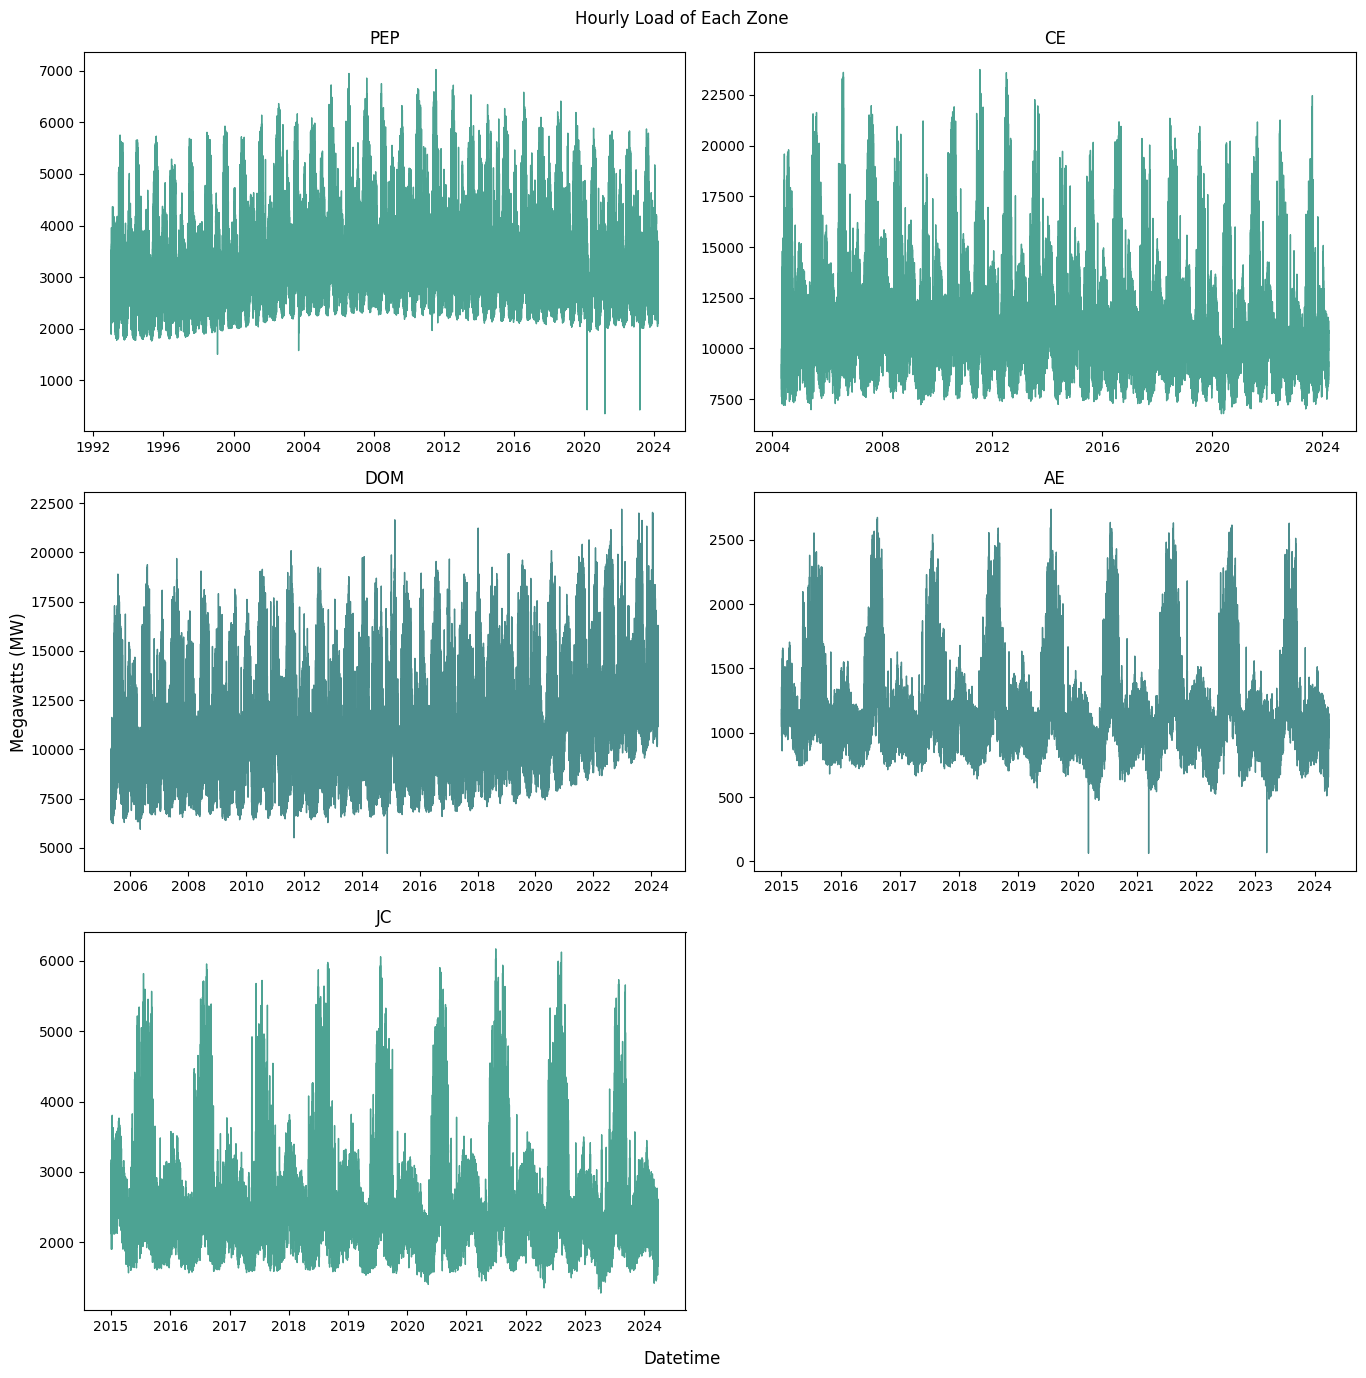

In [201]:
load_zone_plot(load_zone_df, figsize = (14,14), cmap = zones_palette)

In [202]:
load_zone_df.loc[load_zone_df['zone'] == 'PEP']['mw'].quantile([0.00005, 0.01, 0.99, 0.9995])

0.00005    1755.867458
0.01000    2029.000000
0.99000    5626.516500
0.99950    6445.806363
Name: mw, dtype: float64

In [203]:
outliers_index = {}
outliers_z = {}
replacement_medians = {}
for zone in zones:
    outliers_index[zone] = []
    outliers_z[zone] = []
    zone_df = load_zone_df.loc[load_zone_df['zone'] == zone]
    # Find min and max dates for that zone.
    date_min = zone_df['datetime_beginning_ept'].min()
    date_max = zone_df['datetime_beginning_ept'].max()
    # Create tumbling window to locally detect outliers.
    window_size = 35 # Days
    left = date_min
    right = left + pd.Timedelta(days = window_size)
    
    # Tumbling window calculates outlier thresholds 
    # Two methods: Quantile_Thresh = (median +/- (scalar*SD)) or Zscore = z >/< thresh.
    # Wasn't aware of the df.rolling() window method until after, could use instead.
    for i in range(int(((date_max-date_min) / pd.Timedelta(days = window_size)) + 1)):
        if right > date_max:
            right = date_max

        window_df = zone_df.loc[(zone_df['datetime_beginning_ept'].between(left, right, inclusive = 'both'))]

        w_std = window_df['mw'].std()
        w_median = window_df['mw'].median()
        q_lower, q_upper = w_median - (5.75*w_std), w_median + (5.75*w_std) # quantile
        w_mean = window_df['mw'].mean()
        w_zscore = (window_df['mw'] - w_mean) / w_std # zscore

        # Quantile and zscore methods.
        outliers_temp = list(window_df.loc[(window_df['mw'] < q_lower) | (window_df['mw'] > q_upper)].index)
        outliers_z_temp = list(w_zscore.loc[(w_zscore < -5.5) | (w_zscore > 5.5)].index)
        if len(outliers_temp) > 0:
            outliers_index[zone].extend(outliers_temp)
            for i in outliers_temp:
                replacement_medians[i] = round(w_median, 3)
        if len(outliers_z_temp) > 0:
            outliers_z[zone].extend(outliers_z_temp)
        
        left = right + pd.Timedelta(hours = 1)
        right = right + pd.Timedelta(days = window_size)

In [204]:
replacement_medians

{598305: 875.643,
 626861: 919.105,
 671381: 949.514,
 715061: 887.674,
 730185: 974.648,
 583181: 9956.81,
 626862: 9589.354,
 758744: 9422.81,
 261988: 9570.0,
 626863: 10245.839,
 671383: 11317.99,
 715063: 11433.89,
 758745: 12683.774,
 598301: 3105.343,
 642824: 2785.9,
 730181: 2834.333}

In [205]:
outliers_z

{'AE': [598305, 626861, 671381, 715061, 730185],
 'CE': [366819, 583181, 626862, 671382, 758744],
 'DOM': [129939, 261988, 288196, 314405, 626863, 671383, 715063, 758745],
 'JC': [626864, 671384],
 'PEP': [598301, 642824, 671385, 730181, 758741]}

In [206]:
outliers_index

{'AE': [598305, 626861, 671381, 715061, 730185],
 'CE': [583181, 626862, 758744],
 'DOM': [261988, 626863, 671383, 715063, 758745],
 'JC': [],
 'PEP': [598301, 642824, 730181]}

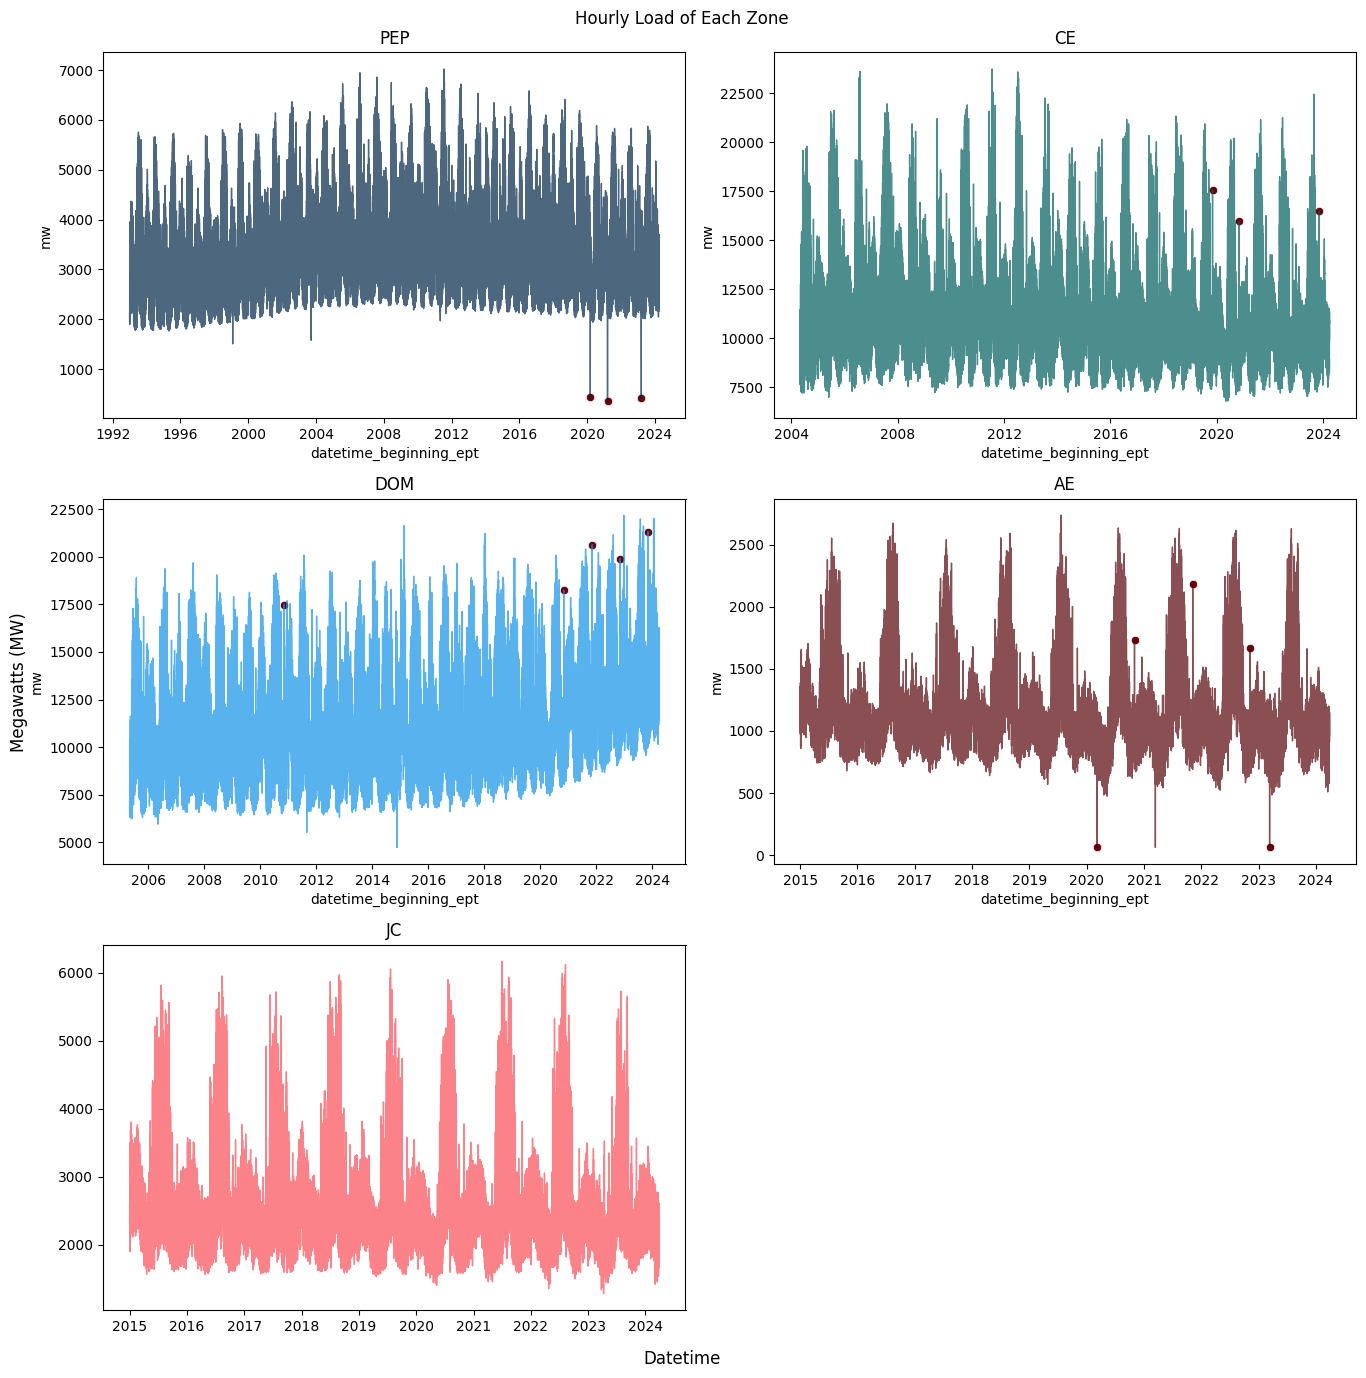

In [208]:
load_zone_plot(load_zone_df, outliers_index, figsize = (14,14), cmap = zones_palette)

In [209]:
for zone in zones:
    display(load_zone_df.iloc[outliers_index.get(zone)])

load_zone_df.loc[replacement_medians.keys(), 'mw'] = list(replacement_medians.values())
    
# for zone, index in outliers_index.items():
#     load_zone_df.drop(outliers_index.get(zone), inplace = True)

,datetime_beginning_ept,zone,mw
598305,2020-03-08 01:00:00,AE,63.719
626861,2020-11-01 01:00:00,AE,1731.123
671381,2021-11-07 01:00:00,AE,2180.259
715061,2022-11-06 01:00:00,AE,1665.363
730185,2023-03-12 01:00:00,AE,68.317


,datetime_beginning_ept,zone,mw
583181,2019-11-03 01:00:00,CE,17586.314
626862,2020-11-01 01:00:00,CE,15989.914
758744,2023-11-05 01:00:00,CE,16491.537


,datetime_beginning_ept,zone,mw
261988,2010-11-07 01:00:00,DOM,17494.000
626863,2020-11-01 01:00:00,DOM,18249.653
671383,2021-11-07 01:00:00,DOM,20633.260
715063,2022-11-06 01:00:00,DOM,19902.046
758745,2023-11-05 01:00:00,DOM,21330.288


,datetime_beginning_ept,zone,mw


,datetime_beginning_ept,zone,mw
598301,2020-03-08 01:00:00,PEP,431.527
642824,2021-03-14 01:00:00,PEP,354.625
730181,2023-03-12 01:00:00,PEP,427.420


In [210]:
load_zone_df.loc[replacement_medians.keys()]

,datetime_beginning_ept,zone,mw
598305,2020-03-08 01:00:00,AE,875.643
626861,2020-11-01 01:00:00,AE,919.105
671381,2021-11-07 01:00:00,AE,949.514
715061,2022-11-06 01:00:00,AE,887.674
730185,2023-03-12 01:00:00,AE,974.648
583181,2019-11-03 01:00:00,CE,9956.810
626862,2020-11-01 01:00:00,CE,9589.354
758744,2023-11-05 01:00:00,CE,9422.810
261988,2010-11-07 01:00:00,DOM,9570.000
626863,2020-11-01 01:00:00,DOM,10245.839


In [211]:
display(load_zone_df.loc[load_zone_df['zone'] == 'AE'].sort_values('mw', ascending = True).head(3))
display(load_zone_df.loc[load_zone_df['zone'] == 'PEP'].sort_values('mw', ascending = True).head(5))
display(load_zone_df.loc[load_zone_df['zone'] == 'DOM'].sort_values('mw', ascending = True).head(3))

outliers_manual = [642823, 642830, 53319, 93914, 93915, 93916, 367978,  598310, 730188, 93913, 93917, 93912]
manual_medians = []

for outlier in outliers_manual:
    zone = load_zone_df.loc[outlier]['zone']
    zone_df = load_zone_df.loc[load_zone_df['zone'] == zone]
    # Find min and max dates for that zone.
    date_min = zone_df['datetime_beginning_ept'].min()
    date_max = zone_df['datetime_beginning_ept'].max()
    # Create indow to calculate median.
    left = zone_df.loc[outlier]['datetime_beginning_ept'] - pd.Timedelta(days = 17)
    right = zone_df.loc[outlier]['datetime_beginning_ept'] + pd.Timedelta(days = 17)
    window_df = zone_df.loc[(zone_df['datetime_beginning_ept'].between(left, right, inclusive = 'both'))]
    w_median = window_df['mw'].median()

    manual_medians.append(round(w_median, 3))

load_zone_df.loc[outliers_manual, 'mw'] = manual_medians

,datetime_beginning_ept,zone,mw
642823,2021-03-14 01:00:00,AE,62.426
605926,2020-05-10 14:00:00,AE,475.194
605923,2020-05-10 13:00:00,AE,475.531


,datetime_beginning_ept,zone,mw
642830,2021-03-14 02:00:00,PEP,1406.669
53319,1999-01-31 15:00:00,PEP,1505.000
93914,2003-09-19 02:00:00,PEP,1578.554
93915,2003-09-19 03:00:00,PEP,1591.057
93916,2003-09-19 04:00:00,PEP,1609.728


,datetime_beginning_ept,zone,mw
367978,2014-11-18 03:00:00,DOM,4724.204
283165,2011-08-28 04:00:00,DOM,5516.000
283162,2011-08-28 03:00:00,DOM,5519.000


In [212]:
load_zone_df.loc[outliers_manual]

,datetime_beginning_ept,zone,mw
642823,2021-03-14 01:00:00,AE,953.865
642830,2021-03-14 02:00:00,PEP,2875.734
53319,1999-01-31 15:00:00,PEP,3150.000
93914,2003-09-19 02:00:00,PEP,3372.739
93915,2003-09-19 03:00:00,PEP,3372.739
93916,2003-09-19 04:00:00,PEP,3372.739
367978,2014-11-18 03:00:00,DOM,10511.681
598310,2020-03-08 02:00:00,PEP,3026.557
730188,2023-03-12 02:00:00,PEP,2929.395
93913,2003-09-19 01:00:00,PEP,3372.877


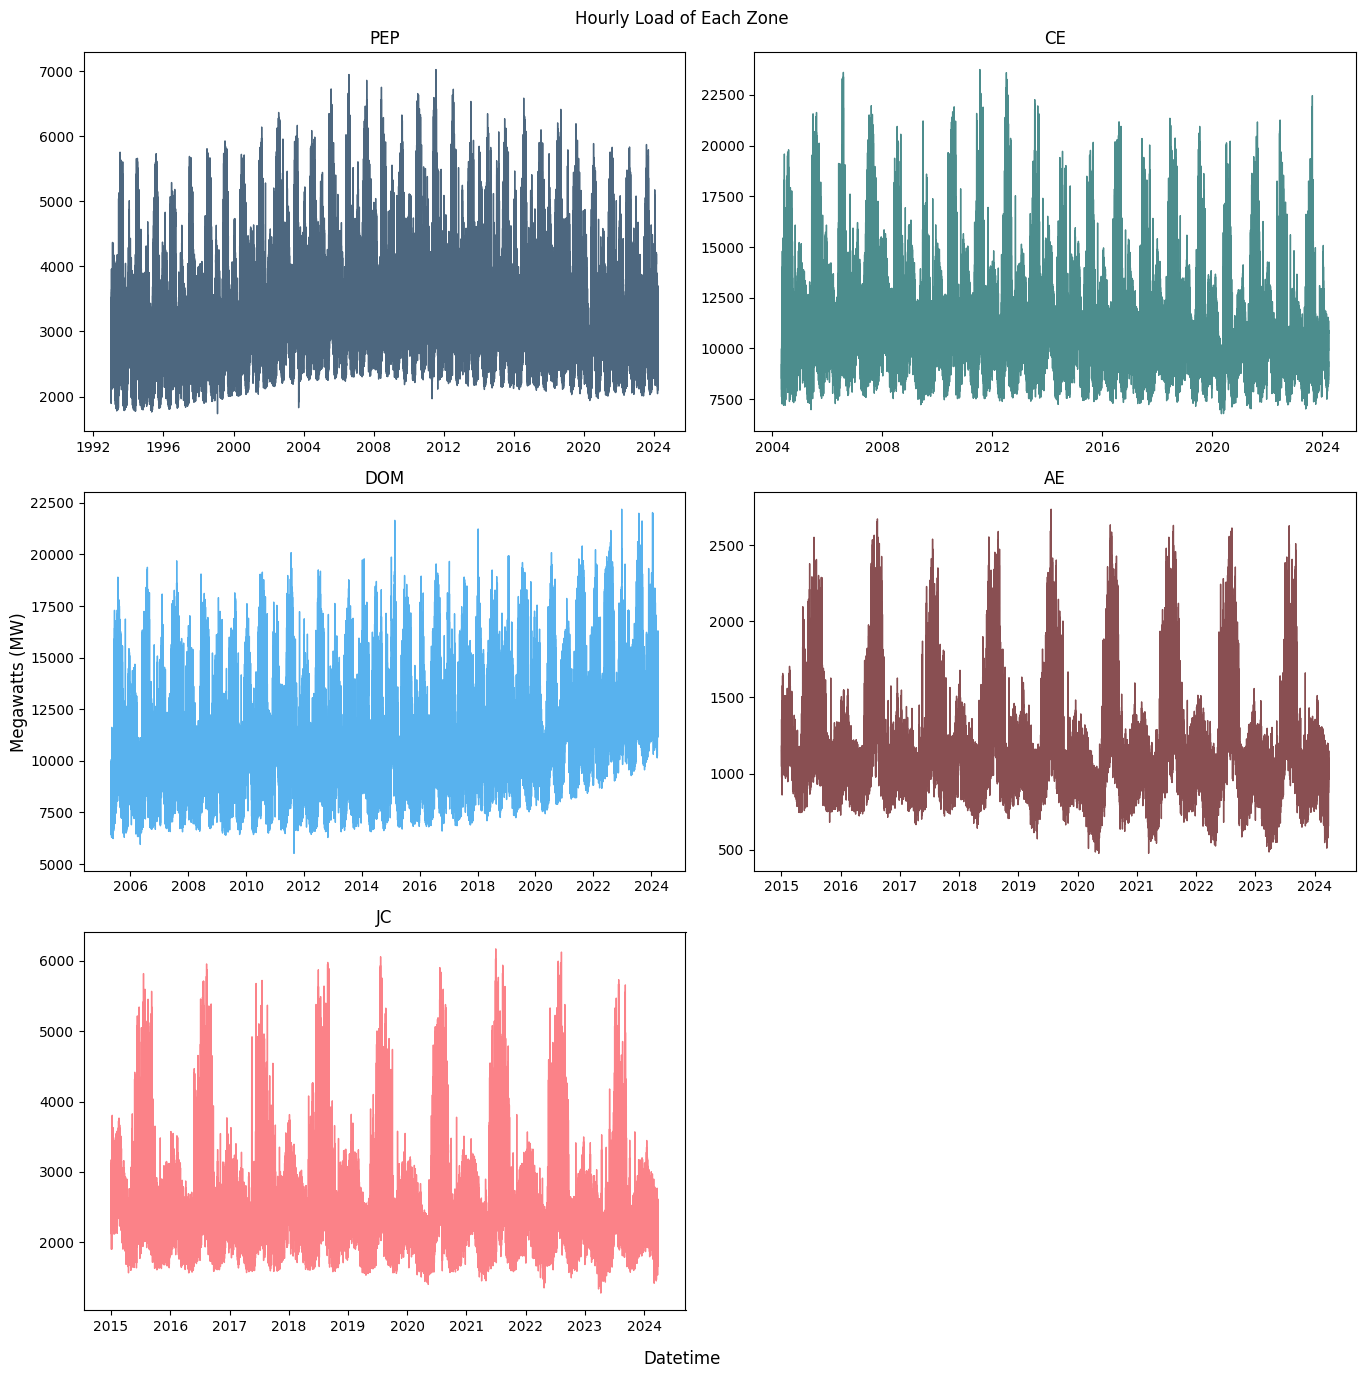

In [213]:
load_zone_plot(load_zone_df, figsize = (14,14), cmap = zones_palette)

### 3.7. Joining Energy Load and Weather: <a name="merge"></a>

In [214]:
load_zone_df.rename(columns = {'datetime_beginning_ept' : 'Date'}, inplace = True)
load_zone_df.reset_index(drop = True, inplace = True)

In [215]:
# Merge
load_df = load_zone_df.merge(weather_df, on = ['Date', 'zone'], how = 'left')

# Sort values by zone and date so we can use .ffill()
load_df.sort_values(by = ['zone', 'Date'], inplace = True)
display(load_df)

# Fill forward weather data up until next day.
load_df.ffill(inplace = True)
# Confirm fill worked.
display(load_df.tail(26))

,Date,zone,mw,MaxTemperature,MinTemperature,AvgTemperature,Precipitation
371136,2015-01-01 00:00:00,AE,1180.082,43.0,17.0,30.0,0.0
371143,2015-01-01 01:00:00,AE,1129.988,NaN,NaN,NaN,NaN
371149,2015-01-01 02:00:00,AE,1088.828,NaN,NaN,NaN,NaN
371151,2015-01-01 03:00:00,AE,1064.563,NaN,NaN,NaN,NaN
371157,2015-01-01 04:00:00,AE,1060.820,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
775991,2024-03-27 19:00:00,PEP,3202.078,NaN,NaN,NaN,NaN
776000,2024-03-27 20:00:00,PEP,3156.612,NaN,NaN,NaN,NaN
776005,2024-03-27 21:00:00,PEP,3035.994,NaN,NaN,NaN,NaN
776009,2024-03-27 22:00:00,PEP,2861.596,NaN,NaN,NaN,NaN


,Date,zone,mw,MaxTemperature,MinTemperature,AvgTemperature,Precipitation
775886,2024-03-26 22:00:00,PEP,2751.947,61.0,39.0,50.0,0.01
775895,2024-03-26 23:00:00,PEP,2608.338,61.0,39.0,50.0,0.01
775897,2024-03-27 00:00:00,PEP,2451.982,50.0,46.0,48.0,0.78
775905,2024-03-27 01:00:00,PEP,2363.249,50.0,46.0,48.0,0.78
775910,2024-03-27 02:00:00,PEP,2337.508,50.0,46.0,48.0,0.78
775912,2024-03-27 03:00:00,PEP,2339.010,50.0,46.0,48.0,0.78
775920,2024-03-27 04:00:00,PEP,2426.600,50.0,46.0,48.0,0.78
775922,2024-03-27 05:00:00,PEP,2626.287,50.0,46.0,48.0,0.78
775930,2024-03-27 06:00:00,PEP,2933.378,50.0,46.0,48.0,0.78
775932,2024-03-27 07:00:00,PEP,3149.023,50.0,46.0,48.0,0.78


## 4. Feature Engineering <a name="feateng"></a>

## 5. Exploratory Data Analysis (EDA) <a name="eda"></a>

In [216]:
def plot_daterange(date_min, date_max, zone_select):
    """Plots MW vs Date in given date range and zone. Interval starts and ends at midnight.
    Note: Some of the text positions break down with larger ranges.
    Ideal range is two-weeks.

    Parameters:
        date_min (string): Date of beginning of interval (inclusive).
        date_max (string): Date of end of interval (inclusive).
        zone_select (string): Zone from load_zone_df to plot.
    
    Returns:
        None. Prints plot to output."""
    
    date_min = pd.to_datetime(f'{date_min} 00:00:00')
    date_max = pd.to_datetime(f'{date_max} 00:00:00')
    date_range = (date_max - date_min).days
    weather_temp = weather_df.loc[(weather_df['Date'].between(date_min, date_max, inclusive='both')) & 
                                (weather_df['zone'] == zone_select)].reset_index(drop = True)

    
    plt.subplots(figsize = (14, 8))
    sns.lineplot(load_zone_df.loc[(load_zone_df['Date'].between(date_min, date_max, inclusive='both')) & 
                                    (load_zone_df['zone'] == zone_select)], 
                    x = 'Date', 
                    y = 'mw',
                    c = zones_palette[zone_select],  
                    alpha = 0.7, lw = 1, marker = 'o')

    # Iterates through each day in range.
    for i in range(date_range + 1):
        # Day separating line.
        plt.axvline(date_min + pd.Timedelta(days = i), color = 'purple', ls = '--')
        if i > date_range-1:
            continue
        # Day of the week.
        plt.text(x = date_min + pd.Timedelta(days = i) + pd.Timedelta(hours = 10),
                    y = (plt.ylim()[0] + plt.ylim()[1]) / 2,
                    s = f'{(date_min + pd.Timedelta(days = i)).day_name()}',
                    rotation = 'vertical',
                    weight='bold',
                    alpha = 0.75)
        # Temperatures.
        # High
        plt.text(x = date_min + pd.Timedelta(days = i) + pd.Timedelta(hours = 6),
                    y = ((plt.ylim()[0] + plt.ylim()[1]) / 2) + ((plt.ylim()[0] + plt.ylim()[1]) / 8),
                    s = f"Hi:{weather_temp['MaxTemperature'].iloc[i]}\N{DEGREE SIGN}",
                    rotation = 'horizontal',
                    alpha = 0.75)
        # Low
        plt.text(x = date_min + pd.Timedelta(days = i) + pd.Timedelta(hours = 6),
                    y = ((plt.ylim()[0] + plt.ylim()[1]) / 2) - ((plt.ylim()[0] + plt.ylim()[1]) / 8),
                    s = f"Lo:{weather_temp['MinTemperature'].iloc[i]}\N{DEGREE SIGN}",
                    rotation = 'horizontal',
                    alpha = 0.75)
    return None

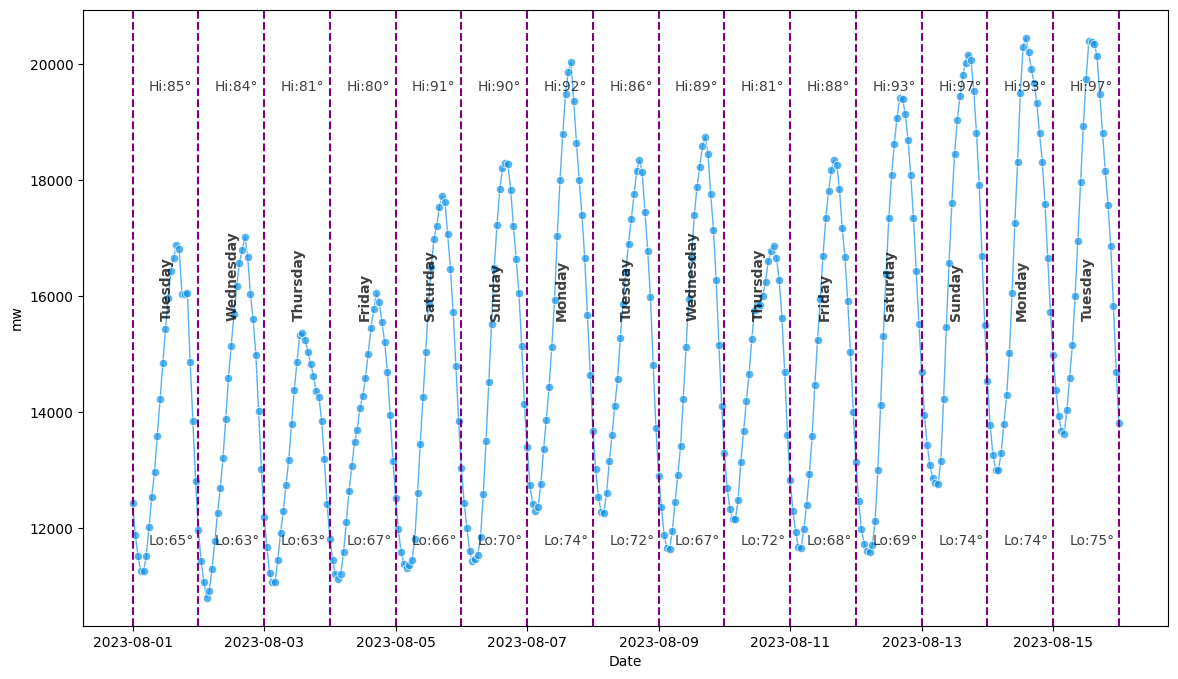

In [217]:
plot_daterange('8/01/2023', '8/16/2023', 'DOM')

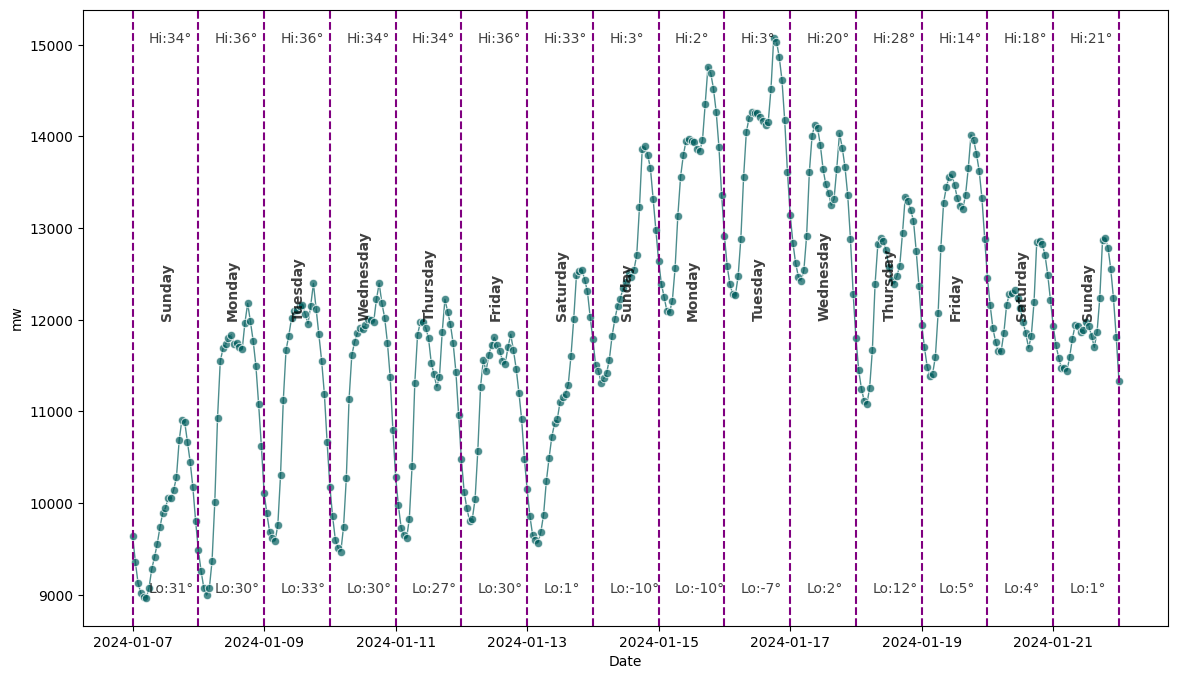

In [218]:
plot_daterange('01/07/2024', '01/22/2024', 'CE')

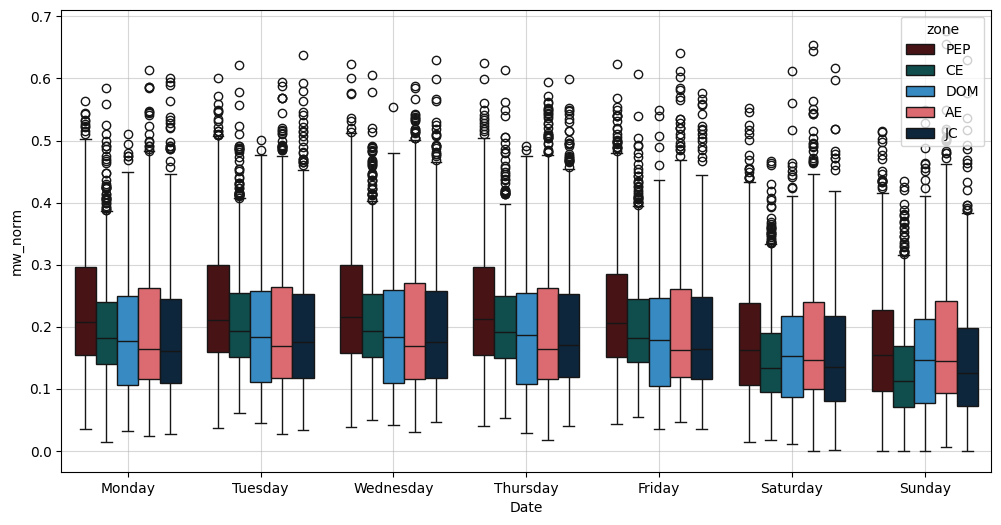

In [219]:
load_day_df = load_zone_df.copy(deep = True)
load_day_df['Date'] = pd.to_datetime(load_day_df['Date'].dt.date)
load_day_df = load_day_df.groupby(['Date', 'zone'], as_index = False).sum()

load_day_df['mw_norm'] = float
for zone in zones:
    mask = load_day_df['zone'] == zone
    temp_df = load_day_df.loc[mask]
    min_mw = temp_df['mw'].min()
    max_mw = temp_df['mw'].max()
    load_day_df.loc[mask, 'mw_norm'] = (temp_df['mw'] - min_mw) / max_mw

palette = ['#570408', '#005d5d', '#1192e8', '#fa4d56', '#012749']
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.subplots(figsize = (12, 6))
sns.boxplot(load_day_df, 
                x = (load_day_df['Date'].dt.day_name()), 
                y = load_day_df['mw_norm'],
                hue = 'zone',
                order = order,
                palette = sns.color_palette(palette, 5),
                saturation = 0.65)
plt.grid(alpha = 0.5)

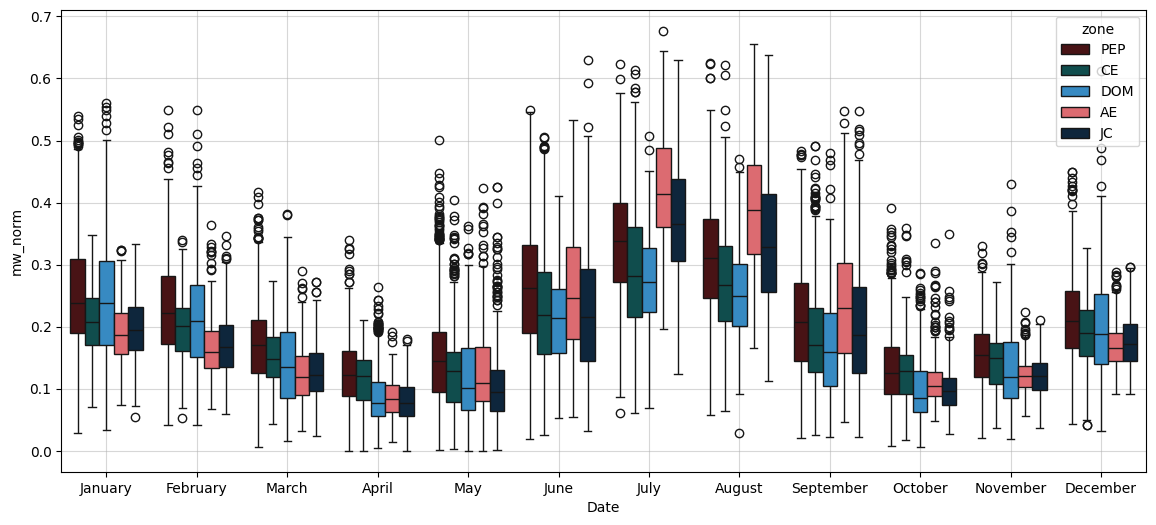

In [220]:
# Month
plt.subplots(figsize = (14, 6))
sns.boxplot(load_day_df, 
                x = (load_day_df['Date'].dt.month_name()), 
                y = load_day_df['mw_norm'],
                hue = 'zone',
                palette = sns.color_palette(palette, 5),
                saturation = 0.65)
plt.grid(alpha = 0.5)

In [363]:
gen_fuel_df = gen_df[['datetime_beginning_ept', 'fuel_type', 'mw']].groupby(['datetime_beginning_ept', 'fuel_type'], as_index = False).sum()

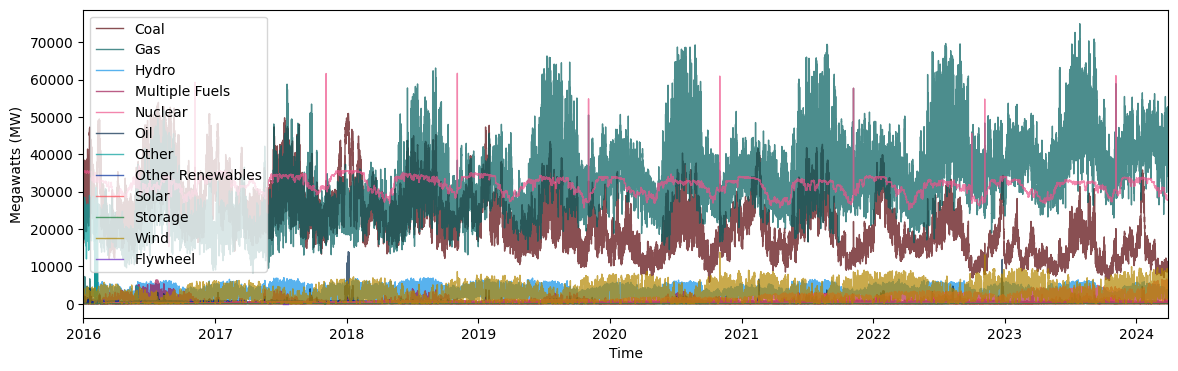

In [364]:
palette = ['#570408', '#005d5d', '#1192e8', '#9f1853', '#ee538b', '#012749', '#009d9a', '#002d9c', '#fa4d56', '#198038', '#b28600', '#6929c4']

ax, fig = plt.subplots(figsize = (14, 4))
ax = sns.lineplot(gen_fuel_df, x = 'datetime_beginning_ept', y = 'mw',  hue = 'fuel_type', alpha = 0.7, lw = 1, palette = sns.color_palette(palette, 12))
ax.margins(x = 0)
ax.set_xlabel('Time')
ax.set_ylabel('Megawatts (MW)')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles = handles, labels = labels)
plt.legend(loc = 'upper left')
plt.show()

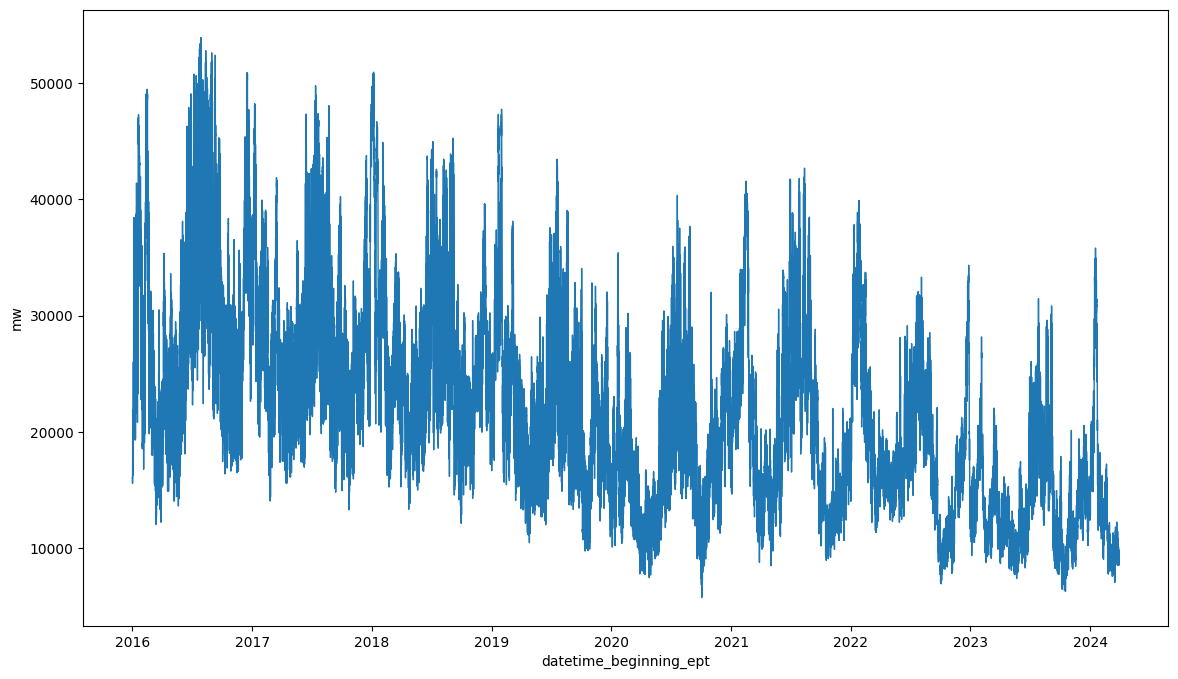

In [365]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Coal'], x = 'datetime_beginning_ept', y = 'mw', lw = 1)

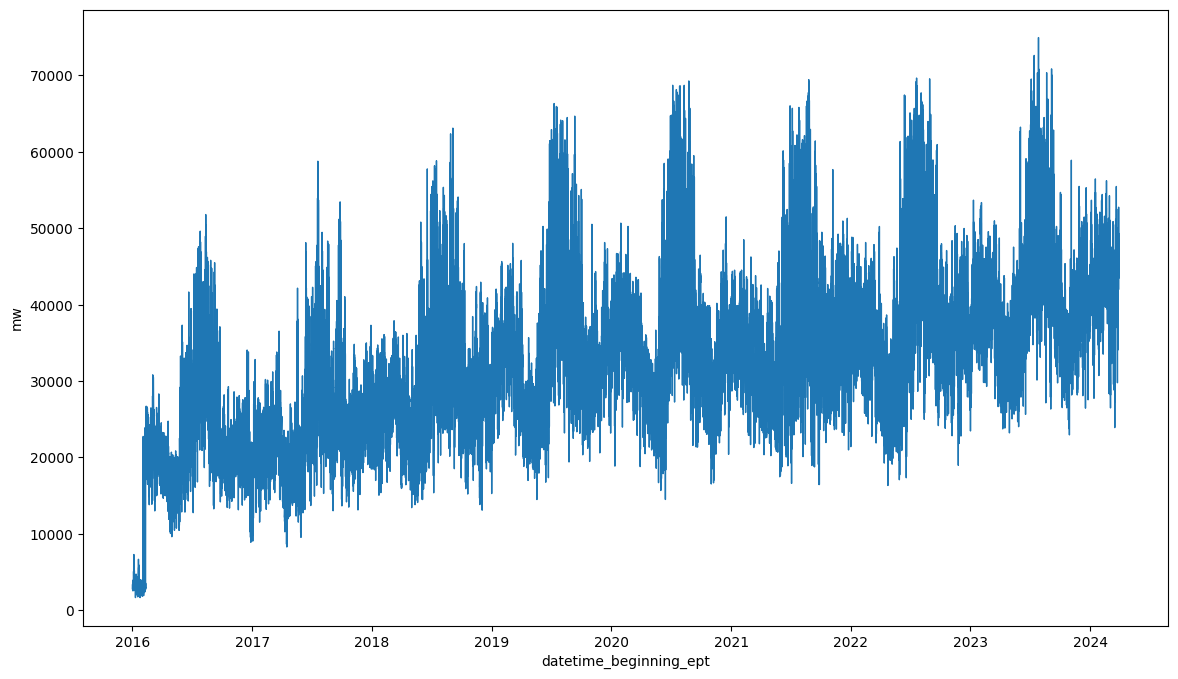

In [366]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Gas'], x = 'datetime_beginning_ept', y = 'mw', lw = 1)

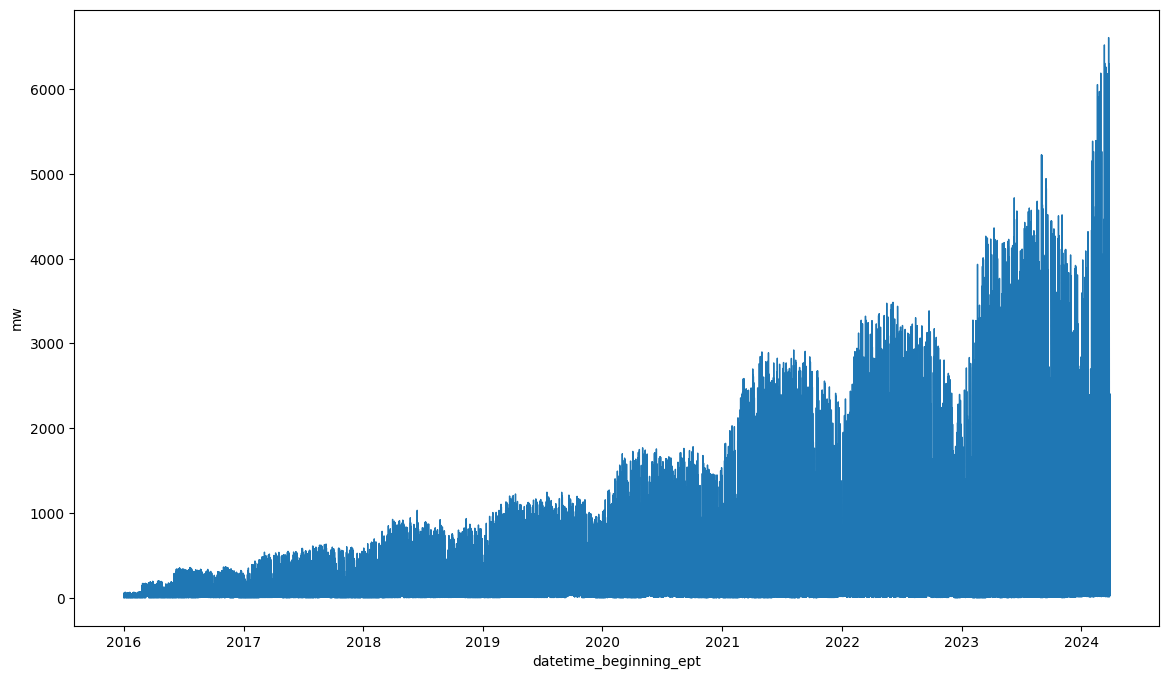

In [367]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Solar'], x = 'datetime_beginning_ept', y = 'mw', lw = 1)

## Seeking the Prophet

---

Just temporarily building a model from Meta's Prophet to use in a few visualizations.

Feelin' cute, might delete later.

In [369]:
df = pd.DataFrame({'ds' : gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Gas']['datetime_beginning_ept'],
                   'y' : gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Gas']['mw']})
m = Prophet()
m.fit(df)

16:48:24 - cmdstanpy - INFO - Chain [1] start processing
16:48:50 - cmdstanpy - INFO - Chain [1] done processing


,ds
72811,2026-03-24 23:00:00
72812,2026-03-25 23:00:00
72813,2026-03-26 23:00:00
72814,2026-03-27 23:00:00
72815,2026-03-28 23:00:00


,ds,yhat,yhat_lower,yhat_upper
72811,2026-03-24 23:00:00,43858.316800,-11378.450592,96098.885990
72812,2026-03-25 23:00:00,43882.657178,-11590.203428,95670.808711
72813,2026-03-26 23:00:00,43271.392986,-13108.224771,94469.399363
72814,2026-03-27 23:00:00,41712.455949,-14652.186106,93975.853198
72815,2026-03-28 23:00:00,38005.122236,-19258.092304,90975.898219


/opt/homebrew/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/homebrew/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


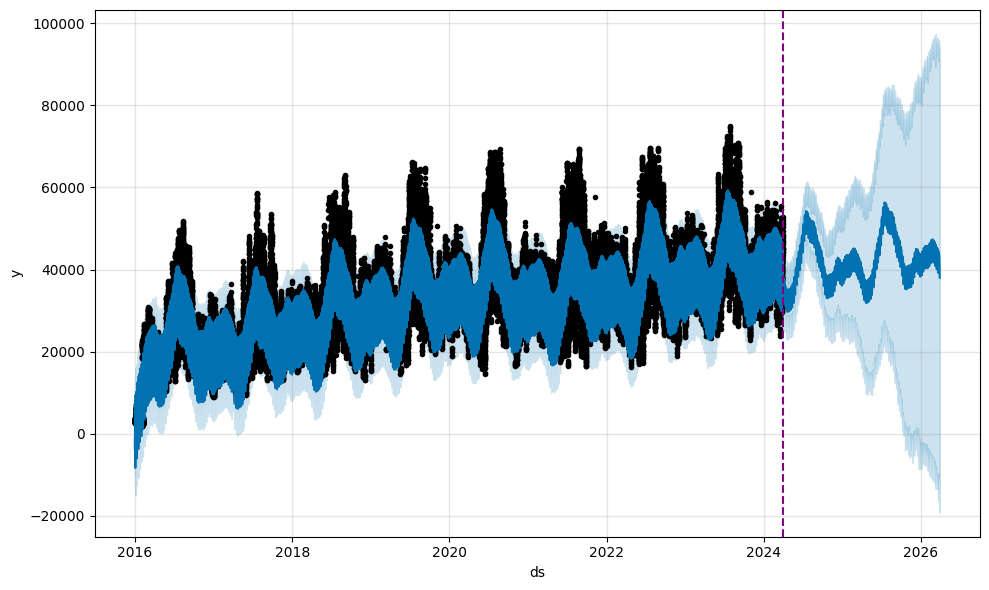

In [370]:
future = m.make_future_dataframe(periods=365*2)
display(future.tail())
forecast = m.predict(future)
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
fig1 = m.plot(forecast)
ax = fig1.gca()
plt.axvline(max(df['ds']), color = 'purple', ls = '--')

In [371]:
# Sourced from the prophet repository and repurposed to include:
# - Delineate observed data and forecasted data (dashed line)
# - Separate observed data and forecasted data for different visuals
# - Color changes
# - Zoom into the last few years to better visualize forecast (currently hardcoded)

def prophetplot(m, fcst, ax=None, uncertainty=True, plot_cap=True, xlabel='Time', ylabel='Megawatts (MW)',
    figsize=(10, 6), include_legend=False):
    """Plot the Prophet forecast.

    Parameters
    ----------
    m: Prophet model.
    fcst: pd.DataFrame output of m.predict.
    ax: Optional matplotlib axes on which to plot.
    uncertainty: Optional boolean to plot uncertainty intervals, which will
        only be done if m.uncertainty_samples > 0.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    xlabel: Optional label name on X-axis
    ylabel: Optional label name on Y-axis
    figsize: Optional tuple width, height in inches.
    include_legend: Optional boolean to add legend to the plot.
    Returns
    -------
    A matplotlib figure.
    """
    user_provided_ax = False if ax is None else True
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    fcst_t = fcst['ds']#.dt.to_pydatetime()

    # Initialize the observation and forecast data variables
    # Finds and separates the two sets by using the max date in (observed) input data.
    obs_t = fcst_t.loc[fcst_t < max(df['ds'])]
    obs_yhat = fcst['yhat'].iloc[ : fcst['ds'].loc[fcst['ds'] <= max(df['ds'])].index[-1]]
    obs_lower = fcst['yhat_lower'].iloc[ : fcst['ds'].loc[fcst['ds'] <= max(df['ds'])].index[-1]]
    obs_upper = fcst['yhat_upper'].iloc[ : fcst['ds'].loc[fcst['ds'] <= max(df['ds'])].index[-1]]
    fc_t = fcst_t.loc[fcst_t >= max(df['ds'])]
    fc_yhat = fcst['yhat'].iloc[fcst['ds'].loc[fcst['ds'] >= max(df['ds'])].index[0]:]
    fc_lower = fcst['yhat_lower'].iloc[fcst['ds'].loc[fcst['ds'] >= max(df['ds'])].index[0]:]
    fc_upper = fcst['yhat_upper'].iloc[fcst['ds'].loc[fcst['ds'] >= max(df['ds'])].index[0]:]

    ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], '.', c = '#012749', markersize = 1, alpha = 0.9,
            label='Observed data points')
    ax.plot(obs_t, obs_yhat, ls='-', c='#005d5d', label='Forecast', lw = 0.75, alpha = 0.9)
    ax.plot(fc_t, fc_yhat, ls='-', c='#382238', label='Predict', lw = 0.75, alpha = 1)
    if 'cap' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['cap'], ls='--', c='k', label='Maximum capacity')
    if m.logistic_floor and 'floor' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['floor'], ls='--', c='k', label='Minimum capacity')
    if uncertainty and m.uncertainty_samples:
        ax.fill_between(obs_t, obs_lower, obs_upper,
                        color='#009d9a', alpha=0.4, label='Uncertainty interval')
        ax.fill_between(fc_t, fc_lower, fc_upper,
                        color='#753f75', alpha=0.4, label='Uncertainty interval')
    # Specify formatting to workaround matplotlib issue #12925
    locator = AutoDateLocator(interval_multiples=False)
    formatter = AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(True, which='major', c='gray', ls='-', lw=0.75, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Zoom in x-axis closer to prediction.
    ax.set_xlim(pd.to_datetime(['2020-01-01 00:00:00', '2026-01-01 00:00:00']))
    ax.set_ylim(0, 90000)

    # Prediction divider line.
    plt.axvline(max(df['ds']), color = 'black', ls = '--', lw = 1.2)

    # Linear trend line to calculate yearly increase.
    obs_poly_fn = np.poly1d(np.polyfit(range(len(obs_t)), obs_yhat, 1))
    plt.plot(obs_t, obs_poly_fn(range(len(obs_t))), c = '#913529')

    fc_poly_fn = np.poly1d(np.polyfit(range(len(fc_t)), fc_yhat, 1))
    plt.plot(fc_t, fc_poly_fn(range(len(fc_t))), c = '#252f9c')

    if include_legend:
        ax.legend()
        plt.legend(loc = 'upper left')
    if not user_provided_ax:
        fig.tight_layout()
    return fig

/var/folders/m8/939h_p3x6fq4_c0w_pfktz840000gn/T/ipykernel_49308/1404529793.py:47: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], '.', c = '#012749', markersize = 1, alpha = 0.9,


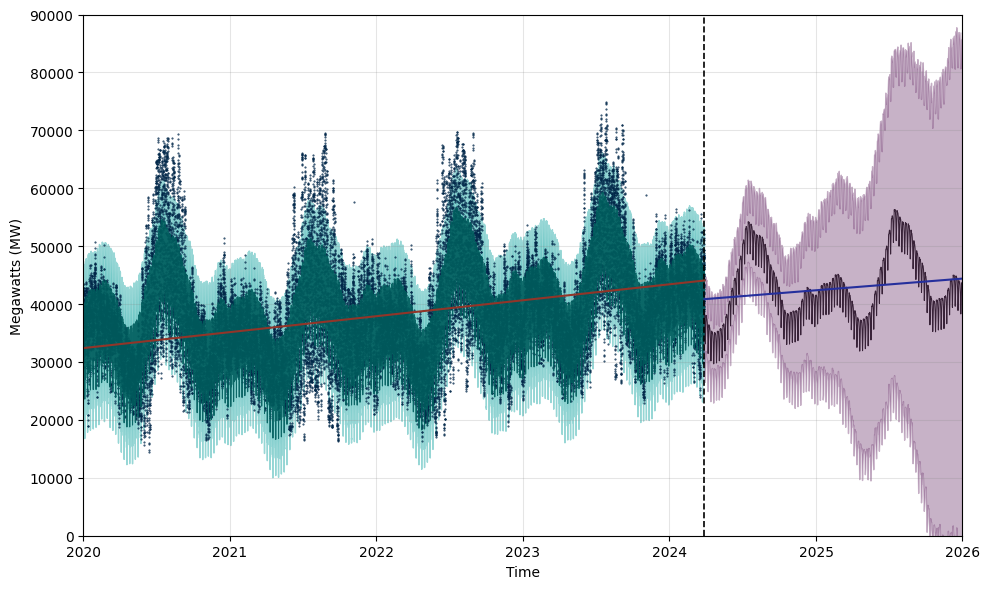

In [372]:
prophetplot(m, forecast)
plt.show()